
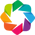

C:\Users\tomaz\Anaconda3\lib\site-packages\statsmodels\compat\pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


In [1]:
import pandas as pd
import ccxt
import datetime
import time
import numpy as np
import sqlite3
from IPython.display import clear_output
import requests
import holoviews as hv
hv.extension('bokeh')
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller, coint
import pandas.io.sql as psql

# Utilizando o pacote ccxt para acessar as moedas negociadas na exchange Poloniex

In [2]:

exchange = ccxt.poloniex()
markets = exchange.load_markets()
markets.keys() 


dict_keys(['BCN/BTC', 'BELA/BTC', 'BLK/BTC', 'BTCD/BTC', 'Bitmark/BTC', 'BTS/BTC', 'BURST/BTC', 'CLAM/BTC', 'DASH/BTC', 'DGB/BTC', 'DOGE/BTC', 'EMC2/BTC', 'FLDC/BTC', 'FLO/BTC', 'GAME/BTC', 'GRC/BTC', 'HUC/BTC', 'LTC/BTC', 'MAID/BTC', 'OMNI/BTC', 'NAV/BTC', 'NEOS/BTC', 'NMC/BTC', 'NXT/BTC', 'PINK/BTC', 'POT/BTC', 'PPC/BTC', 'RIC/BTC', 'XLM/BTC', 'SYS/BTC', 'VIA/BTC', 'XVC/BTC', 'VRC/BTC', 'VTC/BTC', 'XBC/BTC', 'XCP/BTC', 'XEM/BTC', 'XMR/BTC', 'XPM/BTC', 'XRP/BTC', 'BTC/USDT', 'DASH/USDT', 'LTC/USDT', 'NXT/USDT', 'XLM/USDT', 'XMR/USDT', 'XRP/USDT', 'BCN/XMR', 'BLK/XMR', 'BTCD/XMR', 'DASH/XMR', 'LTC/XMR', 'MAID/XMR', 'NXT/XMR', 'ETH/BTC', 'ETH/USDT', 'SC/BTC', 'BCY/BTC', 'EXP/BTC', 'FCT/BTC', 'RADS/BTC', 'AMP/BTC', 'DCR/BTC', 'LSK/BTC', 'LSK/ETH', 'LBC/BTC', 'STEEM/BTC', 'STEEM/ETH', 'SBD/BTC', 'ETC/BTC', 'ETC/ETH', 'ETC/USDT', 'REP/BTC', 'REP/USDT', 'REP/ETH', 'ARDR/BTC', 'ZEC/BTC', 'ZEC/ETH', 'ZEC/USDT', 'ZEC/XMR', 'STRAT/BTC', 'NXC/BTC', 'PASC/BTC', 'GNT/BTC', 'GNT/ETH', 'GNO/BTC', 'G

## Definindo função para baixar moedas selecionadas

In [3]:

def tabela_dados(moeda, total_dias):
    
    agora = datetime.datetime.now()
    data_final = int((agora - datetime.datetime(1970,1,1)).total_seconds())
    
    data_inicial = agora - datetime.timedelta(total_dias)
    data_inicial = int((data_inicial - datetime.datetime(1970,1,1)).total_seconds())
    
    
    url = ('https://poloniex.com/public?command=returnChartData&currencyPair={}&start={}&end={}&period=300').format(moeda,int(
          data_inicial), int(data_final))

    df = pd.read_json(url)
    df['date'] = pd.to_datetime(df.date)
    df.set_index(['date'], inplace=True)
    
    return df


Baixando os dados das moedas com maior volume de negociação na exchange, Ethereum (ETC) e Ripple (XRP). Ambos no mercado de Bitcoin. (Não está demorando muito para baixar)

In [4]:
eth_btc = "BTC_ETH"
xrp_btc = "BTC_XRP"

dados_eth_btc = tabela_dados(eth_btc,365)
dados_xrp_btc = tabela_dados(xrp_btc,365)

Rápida conferência dos dados.
São obtidos dados a cada 5 min (300 segundos). Em um dia, teremos 12 x 24 dados. Em um ano, 12 x 24 x 365 = 105120


In [5]:
print(len(dados_eth_btc))
print(len(dados_xrp_btc))

105120
105120


## Exportando data frames para o SQLite

In [6]:
connection = sqlite3.connect('eth.db')
pd.DataFrame.to_sql(self = dados_eth_btc, name = 'eth', con= connection, index = True, if_exists = 'replace')
connection.close()

In [7]:
connection = sqlite3.connect('xrp.db')
pd.DataFrame.to_sql(self = dados_xrp_btc, name = 'xrp', con= connection, index = True, if_exists = 'replace')
connection.close()

## Importando dados da base para dar início à analise

In [8]:
connection = sqlite3.connect('eth.db')
ohlcv_eth_df = psql.read_sql('select * from eth;', con=connection)
ohlcv_eth_df.set_index('date', inplace = True)
connection2 = sqlite3.connect('xrp.db')
ohlcv_xrp_df = psql.read_sql('select * from xrp;', con=connection2)
ohlcv_xrp_df.set_index('date', inplace = True)

In [9]:
dataframes_dict = {'ETH': ohlcv_eth_df, 'XRP': ohlcv_xrp_df}

## Rápida checagem da base de dados

In [10]:
cur = connection.cursor()
cur2 = connection2.cursor()

def check_sql_table(nome):
    if nome=='ETH':
        cur.execute('SELECT COUNT(date) FROM {}'.format(nome))
        count_lines = cur.fetchone() 
        print('Total de linhas na tabela', nome, '-', count_lines[0], '/', 'Abaixo, os 5 dados mais recentes:')
        print('\r\n')
        recent_rows = pd.read_sql_query('SELECT * FROM {} ORDER BY date DESC LIMIT 5'.format(nome), connection)
        print(recent_rows)
        print('\r\n')
    elif nome=='XRP':
        cur2.execute('SELECT COUNT(date) FROM {}'.format(nome))
        count_lines = cur2.fetchone() 
        print('Total de linhas na tabela', nome, '-', count_lines[0], '/', 'Abaixo, os 5 dados mais recentes:')
        print('\r\n')
        recent_rows = pd.read_sql_query('SELECT * FROM {} ORDER BY date DESC LIMIT 5'.format(nome), connection2)
        print(recent_rows)
        print('\r\n')
        

In [11]:
for data_key,data_val in dataframes_dict.items():
    check_sql_table(data_key)

Total de linhas na tabela ETH - 105120 / Abaixo, os 5 dados mais recentes:


                  date     close      high       low      open  quoteVolume  \
0  2018-01-30 15:30:00  0.107450  0.107684  0.107450  0.107684    79.509963   
1  2018-01-30 15:25:00  0.107684  0.107808  0.107329  0.107681   231.010872   
2  2018-01-30 15:20:00  0.107681  0.107689  0.106990  0.107150   834.146842   
3  2018-01-30 15:15:00  0.107073  0.107200  0.106903  0.106908   151.365162   
4  2018-01-30 15:10:00  0.106990  0.107399  0.106908  0.107399   746.825982   

      volume  weightedAverage  
0   8.557372         0.107626  
1  24.877002         0.107688  
2  89.500295         0.107296  
3  16.204804         0.107058  
4  79.987063         0.107103  


Total de linhas na tabela XRP - 105120 / Abaixo, os 5 dados mais recentes:


                  date     close      high       low      open   quoteVolume  \
0  2018-01-30 15:30:00  0.000112  0.000113  0.000112  0.000113  56472.849316   
1  2018-01-30 15:

## Análise dos dados

Analisando graficamente a evolução dos preços de fechamento de Ether/BTC e XRP/BTC.

In [12]:
df = pd.DataFrame(ohlcv_eth_df.close)
df.rename(columns={'close': 'ETHclosing'}, inplace=True)
df['XRPclosing'] = pd.DataFrame(ohlcv_xrp_df.close)
df = df.sort_index(ascending = True)
df['date'] = df.index

In [13]:
%%opts Curve [width=700, height=500, show_grid=True, tools= ['hover']] {+framewise}
def price_evolution(symbol):
    if symbol == 'XRP':
        e = ohlcv_eth_df['close']
    else:
        e = ohlcv_xrp_df['close']
    df['Evolution'] = e
    
    return hv.Curve(df.iloc[-500:], ('date', 'Date'), ('Evolution','Closing Price'))

stock_symbols = ['ETH', 'XRP',]
pe = hv.DynamicMap(price_evolution, kdims=['Symbol']).redim.values(Symbol=stock_symbols)
pe

:DynamicMap   [Symbol]

Analise gráfica da correlação entre os preços de fechamento Ether/BTC e XRP/BTC.

In [14]:
%%opts Curve [width=700, height=350, show_grid=True] {+framewise}
def corr(w):
    C = df['ETHclosing'].rolling(w).corr(other=df['XRPclosing'])
    df['corrETH'] = C
    return hv.Curve(df.iloc[-1000:], ('date', 'Date'), ('corrETH','Correlation Ether and Ripple'))
    
winsize = {d:corr(d) for d in range(10,62,2)}
excorr = hv.HoloMap(winsize, kdims='Window size')
excorr

:HoloMap   [Window size]
   :Curve   [date]   (corrETH)

Criando e ajustando base de retornos

In [15]:
returns = pd.DataFrame(ohlcv_eth_df.close)
returns.rename(columns={'close': 'ETHclosing'}, inplace=True)
returns['XRPclosing'] = pd.DataFrame(ohlcv_xrp_df.close)
returns = returns.sort_index(ascending = True)
returns['ETHret'] = returns.ETHclosing/returns.ETHclosing.shift(1) - 1
returns['XRPret'] = returns.XRPclosing/returns.XRPclosing.shift(1) - 1
returns['date'] = returns.index

Gráfico de retorno para ETHER - moeda com maior volume de negociação no mercado de Bitcoin da Poloniex.

In [16]:
%%opts Curve [width=800, height=400, show_grid=True, tools=['hover']] {+framewise}
hv.Curve(returns.iloc[-500:], ('date', 'Date'),('ETHret', 'Ether Returns %'), label='Ether returns').hist(num_bins=100)

:AdjointLayout
   :Curve   [date]   (ETHret)
   :Histogram   [ETHret]   (ETHret_frequency)

Gráfico de correlação entre os retornos da Ether/BTC e Ripple/BTC.

In [17]:
%%opts Curve [width=700, height=350, show_grid=True] {+framewise}
def rolling_corr(w):
    S = returns['ETHclosing'].rolling(w).corr(other=returns['XRPclosing'])
    returns['corrETH'] = S
    return hv.Curve(returns.iloc[-1000:], ('date', 'Date'), ('corrETH','Correlation Ether and Ripple'))
    
winsize = {q:rolling_corr(q) for q in range(10,62,2)}
rcorr = hv.HoloMap(winsize, kdims='Window size')
rcorr

:HoloMap   [Window size]
   :Curve   [date]   (corrETH)

Volatilidade do retorno de ambas as criptomoedas analisadas.

In [18]:
%%opts Curve [width=700, height=500, show_grid=True] {+framewise}
def rolling_vol(w, symbol):
    if symbol == 'XRP':
        S = returns['XRPclosing'].rolling(w).std()
    else:
        S = returns['ETHclosing'].rolling(w).std()
    returns['Volatility'] = S

    return hv.Curve(returns.iloc[-2000:], ('date', 'Date'), ('Volatility','Rolling volatility'))

stock_symbols = ['ETH', 'XRP',]

winsize = range(10,60,2)
rvol = hv.DynamicMap(rolling_vol, kdims=['Wsize', 'Symbol']).redim.values(Symbol=stock_symbols).redim.range(Wsize=(10,60))
rvol

:DynamicMap   [Wsize,Symbol]